In [1]:
# -*- coding: utf-8 -*-

"""

Side-Channel Analysis 101
2. differential power analysis on DES simulation

lasf modified 2022.04.26

----------------------------------------------------
Sunghyun Jin
sunghyunjin@korea.ac.kr
https://sunghyunjin.com

Cryptographic Algorithm Lab.

School of Cyber Security,
Korea University,
Republic of Korea

Center for Information Security Technologies (CIST),
Institute of Cyber Security & Privacy (ICSP),
Korea University,
Republic of Korea
----------------------------------------------------
"""
print('')

In [2]:
import numpy as np
import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.resources import INLINE
from bokeh.models import Span
from bokeh.palettes import Spectral11
output_notebook(INLINE)

Loading BokehJS ...

## DES (Data Encryption Standard)
- [wikipedia](https://en.wikipedia.org/wiki/Data_Encryption_Standard)
- [fips 46-3](https://csrc.nist.gov/csrc/media/publications/fips/46/3/archive/1999-10-25/documents/fips46-3.pdf)

## DES simulation

In [3]:
from des import DES

In [4]:
des = DES()

In [5]:
def make_des_key():
    key = np.zeros((8,), dtype = np.uint8)
    for i in range(8):
        tmp = np.random.randint(0, 256, size = (1,))[0]
        if hw[tmp] % 2 == 0:
            tmp |= 0x1
        key[i] = tmp
    return key

In [6]:
def make_des_pt(num):
    return np.random.randint(0, 256, size = (num,8), dtype = np.uint8)

In [7]:
def ks(k):
    ''' des key schedule '''
    keybits = np.unpackbits(k.reshape((-1, 1)), axis = 1).reshape((64,))
    
    des_ = DES()

    buf = np.zeros((56,), dtype=np.uint8)
    for i, j in enumerate(des_.PC_1):
        buf[i] = keybits[j-1]

    C = buf[:28]
    D = buf[28:]

    ls = [
        1, 1, 2, 2, 2, 2, 2, 2,
        1, 2, 2, 2, 2, 2, 2, 1
    ]

    rk = np.zeros((16, 8), dtype=np.uint8)

    for r in range(16):
        for bs in range(ls[r]):
            tmp = C[0]
            C[0:-1] = C[1:]
            C[-1] = tmp
            tmp = D[0]
            D[0:-1] = D[1:]
            D[-1] = tmp

        keybits = np.concatenate([C, D])

        buf = np.zeros((48,), dtype=np.uint8)
        for i, j in enumerate(des_.PC_2):
            buf[i] = keybits[j-1]
        rktmp = np.zeros((8, 8), dtype = np.uint8)
        rktmp[:,2:] = buf.reshape((8,6))
        rk[r,:] = np.packbits(rktmp, axis = 1).reshape((-1,8))

    return rk

In [8]:
hw = np.array([bin(n).count("1") for n in range(0, 2**8)], dtype = np.uint8)

In [9]:
key = make_des_key()
print('Key :', ['%02X' % i for i in key])
key

Key : ['61', '43', 'EF', '5F', 'FD', 'E5', 'BD', '69']


array([ 97,  67, 239,  95, 253, 229, 189, 105], dtype=uint8)

In [10]:
rk = ks(key)
for i, rki in enumerate(rk):
    print('%2d round key :' % (i+1), ''.join(['%02X ' % li for li in rki]))

 1 round key : 3B 2B 39 2B 36 17 3A 01 
 2 round key : 3E 19 0E 37 0E 1B 28 25 
 3 round key : 2D 19 0B 3F 2C 24 32 36 
 4 round key : 2D 35 0B 36 03 12 2E 17 
 5 round key : 2F 25 2F 34 2D 36 03 11 
 6 round key : 27 27 0D 3D 18 38 0D 07 
 7 round key : 23 35 1D 3D 25 2A 16 0E 
 8 round key : 33 35 2F 2D 1B 01 1F 05 
 9 round key : 1F 38 16 3B 1B 2B 03 20 
10 round key : 3F 38 22 1F 18 0E 35 2F 
11 round key : 0F 3A 2A 1E 0B 29 32 1A 
12 round key : 0F 23 32 3E 33 15 15 33 
13 round key : 3F 22 31 3C 03 3C 29 28 
14 round key : 33 2E 38 3C 34 0D 35 14 
15 round key : 33 2B 3C 3E 22 18 1A 3C 
16 round key : 3C 3C 1E 27 20 17 1B 38 


In [11]:
pt = make_des_pt(10000)
print('pt shape : ', pt.shape)
pt[0:10]

pt shape :  (10000, 8)


array([[181, 144, 103, 121, 235, 170,  95,  25],
       [ 30, 247,  86, 206,  56, 255,  12, 132],
       [ 45,  68, 170,  52,  33, 178,  33, 179],
       [ 40,  76,  95, 122,  74,  96, 197, 232],
       [151, 195,  65, 199,  78,  66,  92, 205],
       [ 39, 140,  34, 215, 119,  19, 109,  66],
       [147, 142, 200,  82,  53, 175, 247, 245],
       [228, 135,  73, 165, 190, 161,  84, 186],
       [238, 222, 196,  53, 174,  83, 177, 241],
       [198,  44,  93, 103, 160, 181, 130, 160]], dtype=uint8)

In [12]:
def des_1r_f_sbox(p, k):
    des_ = DES()
    
    rk = ks(k)
    pb = np.unpackbits(p.reshape((-1, 1)), axis = 1).reshape((64,))

    buf = np.zeros((64,), dtype = np.uint8)
    for i, j in enumerate(des_.PI):
        buf[i] = pb[j-1]

    L = buf[:32]
    R = buf[32:]
    
    buf = np.zeros((48,), dtype = np.uint8)
    for i, j in enumerate(des_.E):
        buf[i] = R[j-1]
    buf2 = np.zeros((8, 8), dtype = np.uint8)
    buf2[:,2:] = buf.reshape((8,6))
    buf2 = np.packbits(buf2, axis = 1).reshape((-1,8))[0]
    
    buf = buf2 ^ rk[0,:]
    
    out = np.zeros((8,), dtype = np.uint8)
    for i in range(8):
        out[i] = des_.S[i][((buf[i] >> 4) & 0x2) | (buf[i] & 0x1)][(buf[i] >> 1) & 0xF]

    return out

In [13]:
tmp = des_1r_f_sbox(pt[0], key)
tmp.shape, tmp

((8,), array([ 6,  8,  8,  1,  4, 12,  6,  4], dtype=uint8))

In [14]:
def des_1r_f_sbox_gk(p, gk, ith):
    des_ = DES()
    pb = np.unpackbits(p.reshape((-1, 1)), axis = 1).reshape((64,))

    buf = np.zeros((64,), dtype = np.uint8)
    for i, j in enumerate(des_.PI):
        buf[i] = pb[j-1]

    L = buf[:32]
    R = buf[32:]
    
    buf = np.zeros((48,), dtype = np.uint8)
    for i, j in enumerate(des_.E):
        buf[i] = R[j-1]
    buf2 = np.zeros((8, 8), dtype = np.uint8)
    buf2[:,2:] = buf.reshape((8,6))
    buf2 = np.packbits(buf2, axis = 1).reshape((-1,8))[0]
    
    buf = buf2[ith] ^ gk
    
    out = des_.S[ith][((buf >> 4) & 0x2) | (buf & 0x1)][(buf >> 1) & 0xF]

    return out

In [15]:
tmp = des_1r_f_sbox_gk(pt[0], 0x3F, 7)
tmp

11

### LSB model 

In [16]:
tr = np.zeros((pt.shape[0], 8), dtype = np.float64)
for i in tqdm.tqdm(range(pt.shape[0])):
    tmp = des_1r_f_sbox(pt[i], key)
    tr[i,:] = hw[tmp & 1] + 0.3 * np.random.randn(tmp.shape[0])

100%|███████████████████████████████████| 10000/10000 [00:01<00:00, 5168.68it/s]


In [17]:
ith = 0

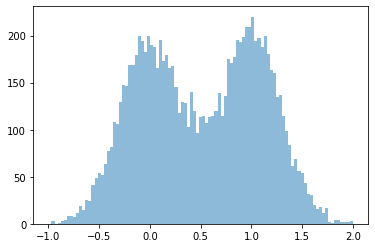

In [18]:
bins = np.linspace(-1, 2, 100)
plt.hist(tr[:,ith], bins, alpha=0.5)
plt.show()

In [19]:
sv = np.zeros((pt.shape[0], 8), dtype = np.uint8)
for i in tqdm.tqdm(range(pt.shape[0])):
    tmp = des_1r_f_sbox(pt[i], key)
    sv[i,:] = hw[tmp & 1]

100%|███████████████████████████████████| 10000/10000 [00:01<00:00, 5149.26it/s]


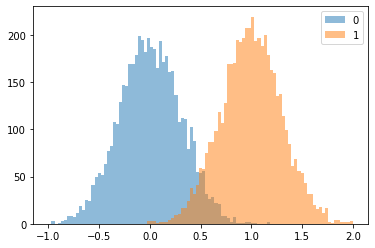

In [20]:
bins = np.linspace(-1, 2, 100)

plt.hist(tr[np.where(sv[:,ith] == 0)[0], ith], bins, alpha=0.5, label='0')
plt.hist(tr[np.where(sv[:,ith] == 1)[0], ith], bins, alpha=0.5, label='1')
plt.legend(loc='upper right')
plt.show()

In [21]:
gk = 61
sv = np.zeros((pt.shape[0],), dtype = np.uint8)
for i in tqdm.tqdm(range(pt.shape[0])):
    sv[i] = hw[des_1r_f_sbox_gk(pt[i], gk, ith) & 1]

100%|██████████████████████████████████| 10000/10000 [00:00<00:00, 55060.56it/s]


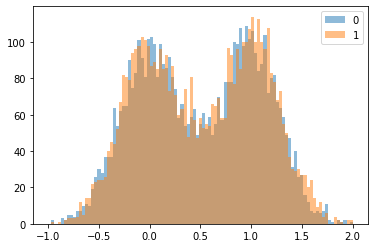

In [22]:
bins = np.linspace(-1, 2, 100)

plt.hist(tr[np.where(sv == 0)[0], ith], bins, alpha=0.5, label='0')
plt.hist(tr[np.where(sv == 1)[0], ith], bins, alpha=0.5, label='1')
plt.legend(loc='upper right')
plt.show()

### HW model 

In [23]:
tr = np.zeros((pt.shape[0], 8), dtype = np.float64)
for i in tqdm.tqdm(range(pt.shape[0])):
    tmp = des_1r_f_sbox(pt[i], key)
    tr[i,:] = hw[tmp] + 0.3 * np.random.randn(tmp.shape[0])

100%|███████████████████████████████████| 10000/10000 [00:01<00:00, 5209.51it/s]


In [24]:
ith = 0

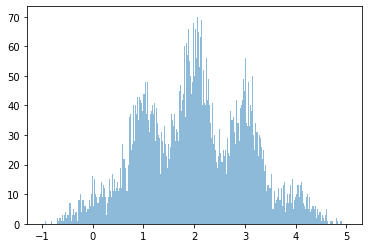

In [25]:
bins = np.linspace(-1, 5, 500)
plt.hist(tr[:,ith], bins, alpha=0.5)
plt.show()

In [26]:
sv = np.zeros((pt.shape[0], 8), dtype = np.uint8)
for i in tqdm.tqdm(range(pt.shape[0])):
    tmp = des_1r_f_sbox(pt[i], key)
    sv[i,:] = hw[tmp & 1]

100%|███████████████████████████████████| 10000/10000 [00:01<00:00, 5230.95it/s]


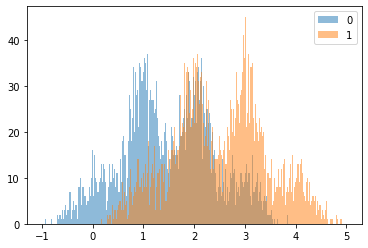

In [27]:
bins = np.linspace(-1, 5, 500)

plt.hist(tr[np.where(sv[:,ith] == 0)[0], 0], bins, alpha=0.5, label='0')
plt.hist(tr[np.where(sv[:,ith] == 1)[0], 0], bins, alpha=0.5, label='1')
plt.legend(loc='upper right')
plt.show()

In [28]:
gk = 61
sv = np.zeros((pt.shape[0],), dtype = np.uint8)
for i in tqdm.tqdm(range(pt.shape[0])):
    sv[i] = hw[des_1r_f_sbox_gk(pt[i], gk, ith) & 1]

100%|██████████████████████████████████| 10000/10000 [00:00<00:00, 58828.37it/s]


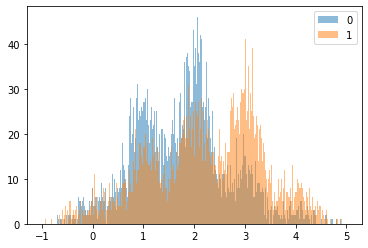

In [29]:
bins = np.linspace(-1, 5, 500)

plt.hist(tr[np.where(sv == 0)[0], ith], bins, alpha=0.5, label='0')
plt.hist(tr[np.where(sv == 1)[0], ith], bins, alpha=0.5, label='1')
plt.legend(loc='upper right')
plt.show()